************************************************************************************************************
* 题目：数据处理
* 制作者:版权所有,柳承睿、蒲鹏 Email:ppu@cc.ecnu.edu.cn；
* 最后更新日期：2022-6-1
* 补充掌握内容： 推荐大家访问官网   https://matplotlib.org/   以及GITHUB资源：https://github.com/search?l=Jupyter+Notebook&p=2&q=matplotlib&type=Repositories
* scipy更多示例：https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bernoulli.html  官方示例和JPT代码
* 声明：在转发并拷贝的过程中，请保留版权信息
************************************************************************************************************

该文件主要对数据进行处理

In [1]:
# %load "mylib\mysql_tool.py"

In [2]:
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import numpy as np
from scipy.optimize import curve_fit
from mylib.mysql_tool import execute_sql
from math import e
from sklearn.linear_model import LassoCV, RidgeCV
# 导入线性回归分类器
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

In [3]:
# 中文字体设置
mpl.rcParams["font.family"] = "SimHei"
# 字体大小设置
mpl.rcParams["font.size"] = 16
# 字体风格设置
mpl.rcParams["font.style"] = "italic"
# 配置坐标轴刻度值模式，显示负号
mpl.rcParams['axes.unicode_minus'] = False
#设置中文字体
fontCN = {
    "family":mpl.rcParams["font.family"],
    "style":mpl.rcParams["font.style"],
    "weight":"normal",
    "color":"green",
    "size": mpl.rcParams["font.size"]
}

## 实验1 获取repoepo_date_weight2019

### 步骤1 该实验的数据来源有handle_data.ipynb的实验输出结果

In [4]:
import pandas as pd
df_repo_date_weight=pd.read_csv("repo_date_weight.csv")
df_repo_date_weight.head(5)

,repo_id,repo_id.1,repo_name,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,...,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,months_not_zero
0,100075549,100075549.0,Azure/autorest.aio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,225.0,225.0,225.0,225.0,225.0,225.0,225.0,225.0,225.0,1.0
1,100118847,100118847.0,Azure/azure-docs-json-samples,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4553.0,4553.0,4553.0,4553.0,4553.0,4553.0,4553.0,4553.0,4553.0,2.0
2,100314903,100314903.0,Azure/autorest.common,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,31751.0,31751.0,31751.0,31751.0,31751.0,31751.0,31751.0,31751.0,31751.0,14.0
3,100315083,100315083.0,Azure/autorest.modeler,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26600.0,26600.0,26600.0,26600.0,26600.0,26600.0,26600.0,26600.0,26600.0,13.0
4,100315457,100315457.0,Azure/autorest.azureresourceschema,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20225.0,20225.0,20225.0,20225.0,20225.0,20225.0,20225.0,20225.0,20225.0,15.0


### 步骤2 绘制所有repo的2019年的权重变化

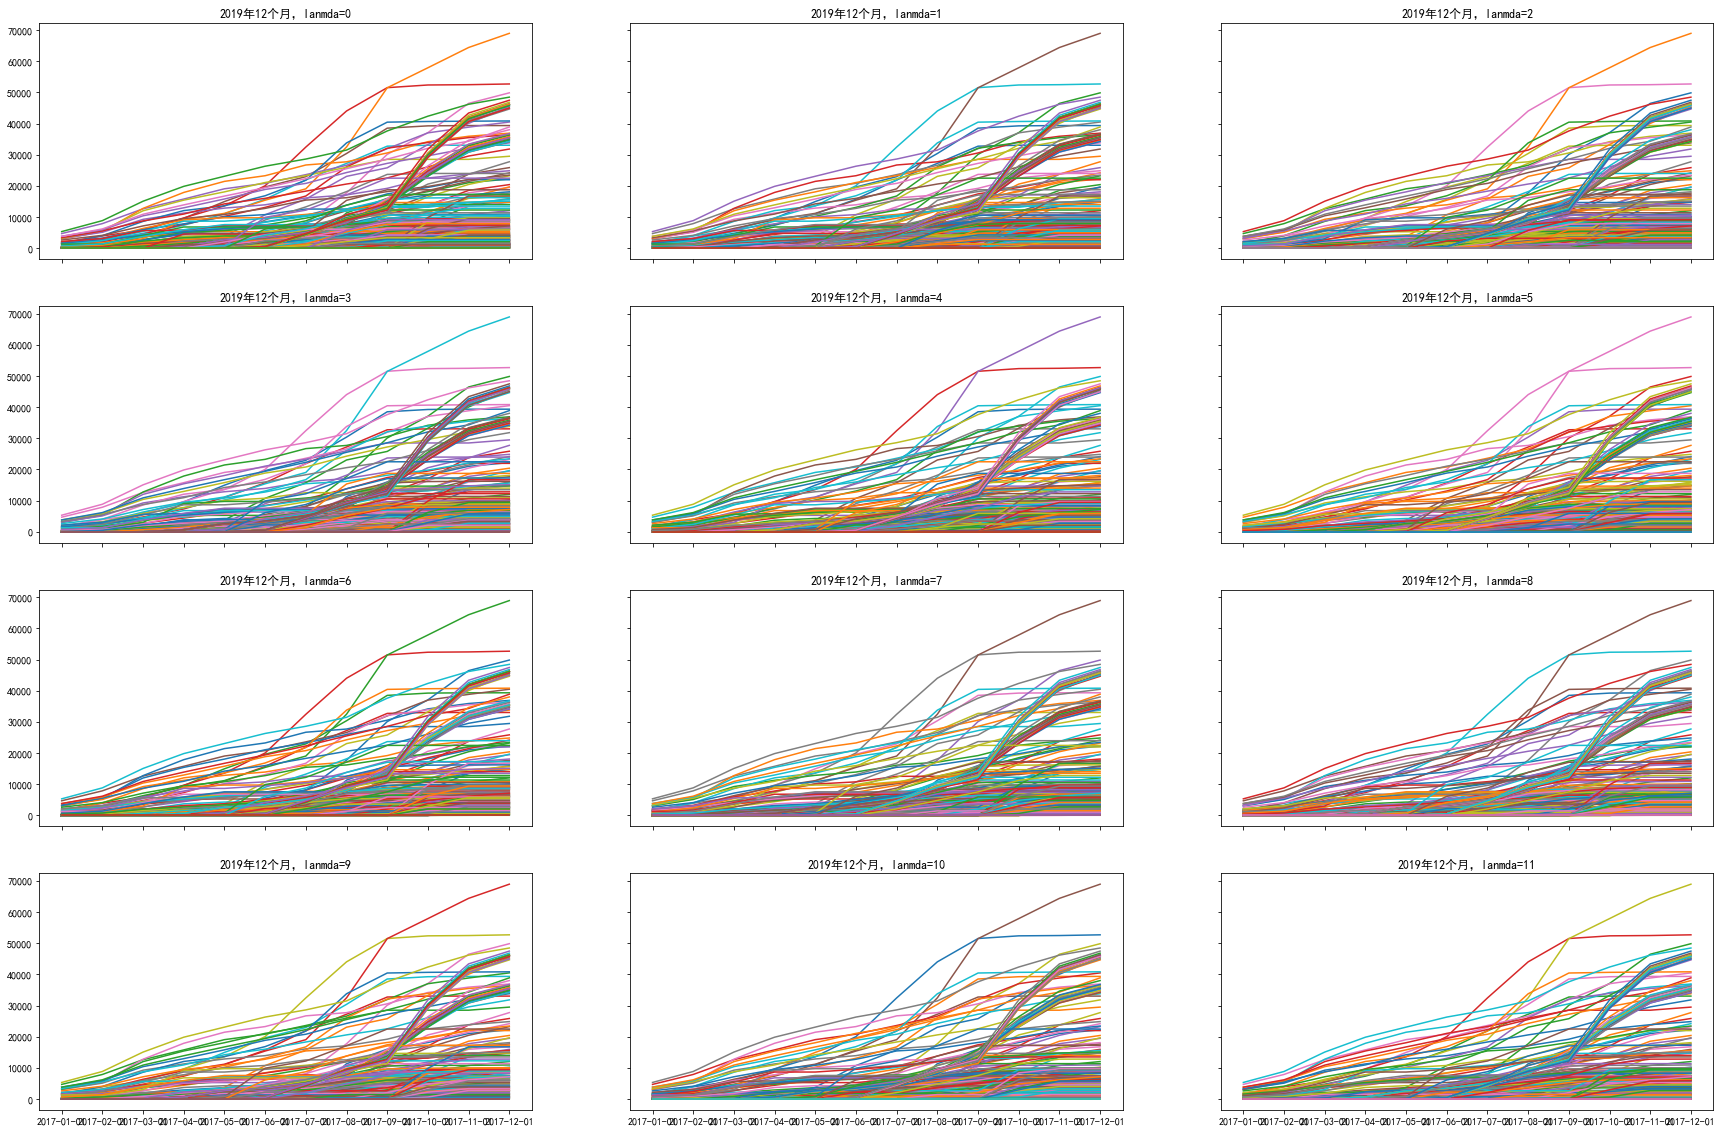

In [5]:
#超参lamda=2  代表统计周期中，发生过度变化的月数
lamda=[[0,1,2],[3,4,5],[6,7,8],[9,10,11]]
# 2行 2列布局的子图
fig4v3 , ax4v3=plt.subplots(4,3,
	sharex=True,
	sharey=True)  #x、y 轴共享属性：刻度标签
fig4v3.set_size_inches(30,20) #画布尺寸
for i in range(0,4):
    for j in range(0,3):
        temp=df_repo_date_weight[df_repo_date_weight['months_not_zero']>lamda[i][j]]
        temp = temp.reset_index(drop=True)
        ax4v3[i,j].set_title(f"2019年12个月，lanmda={lamda[i][j]}")
        for k in range(0,temp.shape[0]):
            row=temp.loc[k]
            #筛选出12个月的列
            ax4v3[i,j].plot(row[3:15])

### 步骤3 预处理（lamda2）

In [82]:
lambda2 = 28
selected_repos=df_repo_date_weight[df_repo_date_weight['months_not_zero']>lambda2]
selected_repos = selected_repos.reset_index(drop=True)
selected_repos.head(5)
print(len(selected_repos))

74


## 实验2 对所有仓库线性回归

### 步骤1 单个仓库线性回归训练

In [7]:
def single_repo_LR(line_index):
    Y_data=np.array(selected_repos.loc[line_index][3:14])
    X_data =np.array( [1,2,3,4,5,6,7,8,9,10,11])
    plt.scatter(X_data,Y_data)
    #实例化对象
    LR1= LinearRegression()
    #调用fit方法 训练模型找规律
    LR1.fit(X_data.reshape(-1, 1),Y_data)
    #找到规律 截距与斜率
    print("斜率与截距:",LR1.coef_,LR1.intercept_)
    Y_pred=X_data*LR1.coef_+LR1.intercept_
    #直接调用库函数进行输出R2
    print("均方误差MSE:",mean_squared_error(Y_data,Y_pred))  
    # #输出RMSE：MSE开根号的结果
    # print("RMSE（MSE开根号）: ",np.sqrt(mean_squared_error(boston_Y_test,boston_Y_predict)))
    # print("平均绝对误差MAE:",mean_absolute_error(boston_Y_test,boston_Y_predict))
    # print("决定系数R方：",r2_score(boston_Y_test,boston_Y_predict))
    plt.plot(X_data,Y_pred)
    return mean_squared_error(Y_data,Y_pred)

### 步骤2 绘制某个lamda条件下所有的仓库的线性回归

斜率与截距: [2127.19090909] -7470.690909090917
均方误差MSE: 20461202.610743806
斜率与截距: [1741.30909091] -5973.672727272729
均方误差MSE: 11858672.4661157
斜率与截距: [1651.86363636] -5643.0000000000055
均方误差MSE: 10481154.1446281
斜率与截距: [1428.13636364] -5034.36363636364
均方误差MSE: 9517994.243801653
斜率与截距: [1087.30909091] -3965.127272727275
均方误差MSE: 8080131.242975205
斜率与截距: [727.00909091] -2619.8727272727283
均方误差MSE: 3263012.8752066107
斜率与截距: [275.37272727] -985.9636363636371
均方误差MSE: 483097.1727272728
斜率与截距: [498.31818182] -1840.3636363636374
均方误差MSE: 1886673.7809917354
斜率与截距: [215.17272727] -755.3090909090913
均方误差MSE: 302920.4454545455
斜率与截距: [0.] 0.0
均方误差MSE: 0.0
斜率与截距: [0.] 0.0
均方误差MSE: 0.0
斜率与截距: [0.] 0.0
均方误差MSE: 0.0
斜率与截距: [0.] 0.0
均方误差MSE: 0.0
斜率与截距: [0.] 0.0
均方误差MSE: 0.0
斜率与截距: [0.] 0.0
均方误差MSE: 0.0
斜率与截距: [0.] 0.0
均方误差MSE: 0.0
斜率与截距: [0.] 0.0
均方误差MSE: 0.0
斜率与截距: [0.] 0.0
均方误差MSE: 0.0
斜率与截距: [0.] 0.0
均方误差MSE: 0.0
斜率与截距: [0.] 0.0
均方误差MSE: 0.0
斜率与截距: [0.] 0.0
均方误差MSE: 0.0
斜率与截距: [0.] 0.0
均方误差MSE: 0.0
斜率与

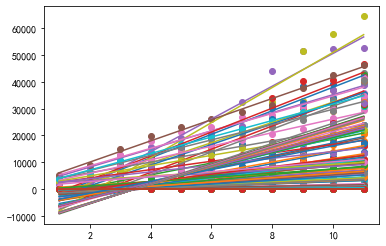

In [8]:
LR_MSE=[]
for i in range(0,selected_repos.shape[0]):
   LR_MSE.append( single_repo_LR(i))

# 这里引发思考，数据要考虑连续年初和年末几个月没有变化的真实情况，年初可能是这个仓库还没上线，年末这个仓库是不是下线了？ 基于这个情况，我们的时间线是不是拉长一点？

## 实验3   对所有仓库BB FIT

### 步骤1 定义BB拟合函数

In [76]:
def BB_fitFun(x, a, b):
    return b * (x ** a)
#单个仓库进行BB-FIT
def single_repo_BB_fit(X_data, Y_data):
    plt.scatter(X_data,Y_data)
    popt_1, pcov_1 = curve_fit(BB_fitFun, X_data, Y_data,maxfev=500)
    print("回归系数:",popt_1)
    # 用回归系数，计算预测值
    #Y_pred = [BB_fitFun(i, popt_1[0], popt_1[1]) for i in x_data]
    Y_pred=BB_fitFun(X_data,popt_1[0], popt_1[1])
    print(Y_pred)
    plt.plot(X_data,Y_pred)
    return mean_squared_error(Y_data,Y_pred)



### 步骤2 梯度下降求解适应度

In [95]:
def loss(b, ita, X_data, Y_data):
    res = 0
    for i in range(len(X_data)):
        res += (b * X_data[i] ** ita - Y_data[i]) ** 2
    return res

# 梯度下降法
def gradient_descent(X_data, Y_data):
    times = 300000 # 迭代次数
    alpha_b = 1e-5 # 初始步长
    alpha_ita = 1e-10 # 初始步长
    b = 10 # b的初始值
    ita = 1 # ita的初始值

    # 梯度下降算法
    n = len(X_data)
    for i_round in range(times):
        new_b = b
        new_ita = ita
        for i in range(n):
            new_ita -= alpha_ita * (1/n) * 2 * (b * X_data[i] ** ita - Y_data[i]) * b * np.log(X_data[i]) * X_data[i] ** ita
            new_b -= alpha_b * (1/n) * 2 * (b * X_data[i] ** ita - Y_data[i]) * X_data[i] ** ita
        f = loss(new_b, new_ita, X_data=X_data, Y_data=Y_data)
        # print("第%d次迭代: b=%f, ita=%f, loss=%f" % (i_round + 1, new_b, new_ita, f))
        b = new_b
        ita = new_ita
    Y_pred=BB_fitFun(X_data, ita, b)
    print(Y_pred)
    plt.plot(X_data,Y_pred)
    return mean_squared_error(Y_data,Y_pred)

# 梯度下降法
def gradient_descent_1(X_data, Y_data):
    times = 300000 # 迭代次数
    alpha_b = 1e-5 # 初始步长
    alpha_ita = 1e-10 # 初始步长
    b = 10 # b的初始值
    ita = 1 # ita的初始值

    # 梯度下降算法
    n = len(X_data)
    for i_round in range(times):
        # 模拟退火的思想，随时间减小学习率，以更好地收敛
        if i_round % 100000 == 0:
            alpha_b = alpha_b / 2
            alpha_ita = alpha_ita / 2
        new_b = b
        new_ita = ita
        for i in range(n):
            new_ita -= alpha_ita * (1/n) * 2 * (b * X_data[i] ** ita - Y_data[i]) * b * np.log(X_data[i]) * X_data[i] ** ita
            new_b -= alpha_b * (1/n) * 2 * (b * X_data[i] ** ita - Y_data[i]) * X_data[i] ** ita
        f = loss(new_b, new_ita, X_data=X_data, Y_data=Y_data)
        # print("第%d次迭代: b=%f, ita=%f, loss=%f" % (i_round + 1, new_b, new_ita, f))
        b = new_b
        ita = new_ita
    Y_pred=BB_fitFun(X_data, ita, b)
    print(Y_pred)
    plt.plot(X_data,Y_pred)
    return mean_squared_error(Y_data,Y_pred)

# 随机梯度下降法
def stochastic_gradient_descent(X_data, Y_data):
    times = 500000 # 迭代次数
    alpha_b = 1e-4 # 初始步长
    alpha_ita = 1e-9 # 初始步长
    b = 10 # b的初始值
    ita = 1 # ita的初始值

    # 梯度下降算法
    n = len(X_data)
    for i_round in range(times):
        new_b = b
        new_ita = ita
        i = np.random.randint(0, n-1)
        new_ita -= alpha_ita * (1/n) * 2 * (b * X_data[i] ** ita - Y_data[i]) * b * np.log(X_data[i]) * X_data[i] ** ita
        new_b -= alpha_b * (1/n) * 2 * (b * X_data[i] ** ita - Y_data[i]) * X_data[i] ** ita
        f = loss(new_b, new_ita, X_data=X_data, Y_data=Y_data)
        # print("第%d次迭代: b=%f, ita=%f, loss=%f" % (i_round + 1, new_b, new_ita, f))
        b = new_b
        ita = new_ita
    Y_pred=BB_fitFun(X_data, ita, b)
    print(Y_pred)
    plt.plot(X_data,Y_pred)
    return mean_squared_error(Y_data,Y_pred)

### 步骤3 对单个仓库进行BB_FIT

[ 207.89581622  416.2977048   624.89103547  833.60878624 1042.41910378
 1251.30321787 1460.24872116 1669.24679257 1878.29083486 2087.37572614
 2296.49737388 2505.65243246 2714.83811557 2924.05206661 3133.29226628
 3342.55696496 3551.84463199 3761.15391699]
861039.8828047918
[ 144.19464659  318.0747738   505.25508806  701.63188523  905.1434247
 1114.52749215 1328.92476238 1547.70935304 1770.40347923 1996.62953428
 2226.0810058  2458.50375407 2693.68339146 2931.43645195 3171.60401976
 3414.04701225 3658.64260996 3905.2815032 ]
870634.9518420971


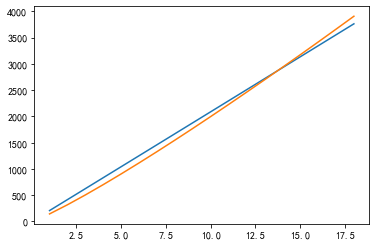

In [92]:
index_of_repo = 6
# 获取仓库创造的时间节点
start_col = 3
for i in range(3,66):
    if selected_repos.loc[index_of_repo][i] != 0:
        start_col = i
        break

print(gradient_descent(X_data=np.array( [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]), Y_data=np.array(selected_repos.loc[index_of_repo][start_col:start_col+18])))
print(gradient_descent_1(X_data=np.array( [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]), Y_data=np.array(selected_repos.loc[index_of_repo][start_col:start_col+18])))

### 步骤4 对所有仓库进行BB拟合,比较传统梯度下降和随机梯度下降的误差

[11703.56236279 15848.63233882 18924.13238021 21461.76858164
 23662.19213658 25626.52354283 27414.03299633 29062.91854116
 30599.46837061 32042.66973408 33406.75511855 34702.71163279
 35939.22650627 37123.30625625 38260.69725763 39356.18031278
 40413.78242751 41436.93252841]
[ 8793.94133811 12871.64660886 16084.82985648 18840.16279542
 21298.44169776 23543.28255286 25624.88716803 27576.24917342
 29420.4545567  31174.41933176 32850.98573191 34460.18132049
 36010.01702022 37507.01526623 38956.57222915 40363.21377537
 41730.78099947 43062.56768906]
[ 7914.17522875 11247.93361851 13815.83898536 15986.00069238
 17901.42694727 19635.60766595 21232.26608576 22719.92588188
 24118.42060003 25442.20416653 26702.19697383 27906.88924646
 29063.03726243 30176.12228696 31250.66417701 32290.44224451
 33298.65485302 34278.03732561]
[ 6138.59669583  9348.01168995 11955.3620529  14235.39073919
 16299.32448538 18205.9304049  19990.92484069 21678.01626898
 23283.93424393 24821.02724408 26298.7308199  2772

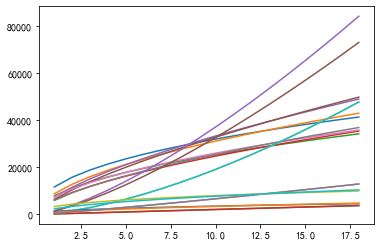

In [96]:
BB_MSE_1=[]
BB_MSE_2=[]
# for index_of_repo in range(0,selected_repos.shape[0]):
for index_of_repo in range(0,10):
    start_col = 3
    # 获取仓库创造的时间节点
    for i in range(3,66):
        if selected_repos.loc[index_of_repo][i] != 0:
            start_col = i
            break
    BB_MSE_1.append(gradient_descent(X_data=np.array( [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]), Y_data=np.array(selected_repos.loc[index_of_repo][start_col:start_col+18])))
    BB_MSE_2.append(gradient_descent_1(X_data=np.array( [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]), Y_data=np.array(selected_repos.loc[index_of_repo][start_col:start_col+18])))
print(BB_MSE_1)
print(BB_MSE_2)

## 实验3 对比所有仓库的线性回归和BB回归

### 步骤1 所有仓库的MSE堆叠柱状图作为指标对比

<AxesSubplot:title={'center':'所有仓库的BB MSE'}, ylabel='误差'>

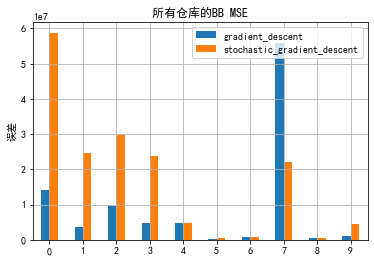

In [94]:
dfBar=pd.DataFrame({
        'gradient_descent':BB_MSE_1,
        'stochastic_gradient_descent':BB_MSE_2
    }, 
    index=np.arange(0,len(BB_MSE_1))  #设置行索引，在绘图的时候，会作用到横坐标轴
)
#print(dfBar)
#两列表合并，用于计算 y轴上下限

dfBar.plot.bar(
    rot=0, ylabel='误差', grid=True,
    title="所有仓库的BB MSE"
)

### 步骤2 所有仓库的MSE误差图对比

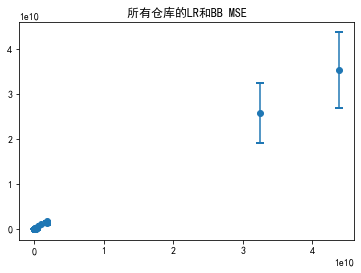

In [ ]:
# 生成数据
x= np.arange(0,len(LR_MSE))
xe = np.array(BB_MSE)-np.array(LR_MSE)
plt.errorbar(LR_MSE, BB_MSE, yerr = xe, fmt='o', capsize=4, capthick=2)
plt.title("所有仓库的LR和BB MSE")
plt.show()